## Set up a SparkSession connected to the socket create with Tweepy

In [17]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('streamTwitterTags').getOrCreate()

In [18]:
from pyspark.sql.functions import lower, split, explode, substring, count

# get tweets
tweets = spark.readStream.format("socket").option("host", "127.0.0.1").option("port", 5555).load()

# convert to lowercase and split the words
words_train = tweets.select(split(lower(tweets.value), " ").alias("value"))

# 'explode' a list of words into rows with single word
words_df = words_train.select(explode(words_train.value).alias('word_explode'))

# keep only rows that the word starts with '#'
hashtags = words_df.filter(substring(words_df.word_explode,0,1)=='#')
hashtags = hashtags.select(hashtags.word_explode.alias('hashtag'))

# count hashtags
count_hashtags = hashtags.groupBy('hashtag').count()
count_hashtags_order = count_hashtags.orderBy(count_hashtags['count'].desc())

## Before proceed, go to the directory with the tweepy code and run the file

## Several ways to get the output

## 1. Show output in console

In [12]:
query = count_hashtags_order.writeStream.outputMode("complete").format("console").start()

## 2. Keep output in memory (careful when using with heavy streaming)
create a table specified in `.queryName("tableName")` which can later be queried on

In [21]:
query = count_hashtags_order.writeStream.outputMode("complete").format("memory").queryName("topTagsTable").start()

In [22]:
# interactively query in-memory table
spark.sql("select * from topTagsTable").limit(11).show()

+-------+-----+
|hashtag|count|
+-------+-----+
+-------+-----+



### Real-time plot of top hashtags from the in-memory table

In [23]:
import os
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from IPython import display

%matplotlib inline

start time: 2018-01-07 12:16:29
current time: 2018-01-07 12:21:33


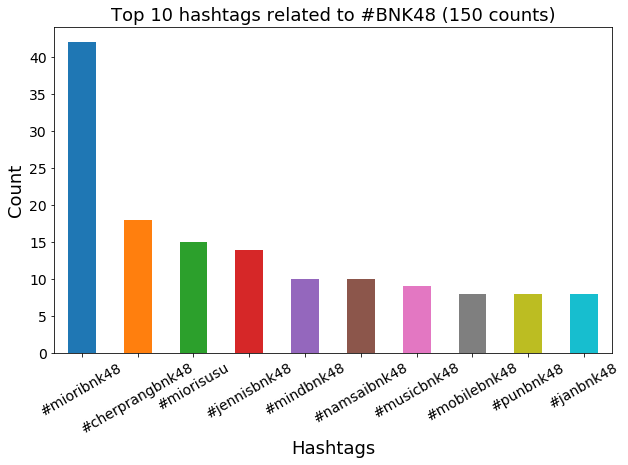

In [24]:
# interactively query in-memory table

start_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

count = 0
while count < 20:
    time.sleep( 15 )    
    display.clear_output(wait=True)
    
    top_hashtags = spark.sql("select * from topTagsTable").limit(11)
#     top_hashtags.show()
    
    top_hashtags = top_hashtags.toPandas()

    bnk48_count = top_hashtags[top_hashtags['hashtag']=='#bnk48']['count'].values

    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    print("start time:", start_time)
    print("current time:", current_time)
    
    fig, ax = plt.subplots(1,1,figsize=(10,6)) 
    top_hashtags[top_hashtags['hashtag']!='#bnk48'].plot(kind='bar', x='hashtag', y='count', legend=False, ax=ax)
    ax.set_title("Top 10 hashtags related to #BNK48 (%d counts)" % bnk48_count, fontsize=18)
    ax.set_xlabel("Hashtags", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), {"fontsize":14}, rotation=30)
#     ax.set_yticklabels(ax.get_yticklabels(), {"fontsize":14}, rotation=30) -- this does not work, may be a bug
    ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # show only integer yticks
    plt.yticks(fontsize=14)
    plt.show()
    
    count += 1

## 3. Write output to a file (csv, json, ...), have to specify checkpoint, saving location (fault tolerant)
* 'complete' mode not available for csv
* aggregation is not supported in 'append' mode

In [120]:
query = hashtags.writeStream.trigger(processingTime='0 seconds').outputMode("append").format("csv")\
.option("checkpointLocation", "checkpoint")\
.option("path", "twitterTags").start()

In [4]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

%matplotlib inline

### Plot top hashtags by calling saved csv files

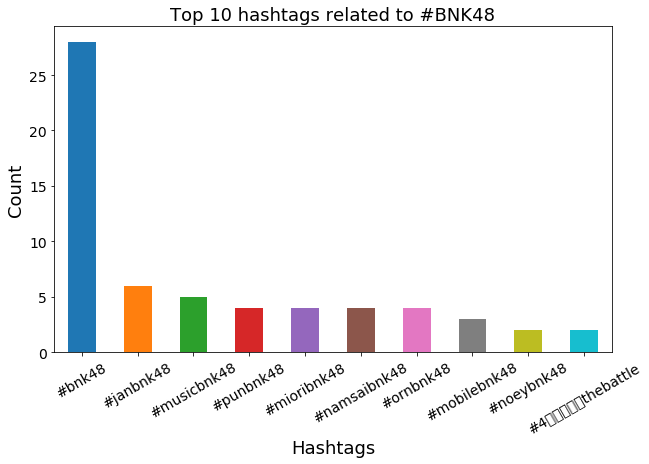

In [34]:
folder = 'twitterTags'

count = 0
while count < 3:
    
    time.sleep( 3 )
    filelist = [name for name in os.listdir(folder) if name[-3:]=='csv']

    df = pd.DataFrame(columns=['twitterTag'])

    for filename in filelist:
        df = pd.concat([df, pd.read_csv(folder+'/'+filename, header=None, names=['twitterTag'])], 
                       ignore_index=True)
        
    top_ten = df.groupby('twitterTag')['twitterTag'].count().sort_values(ascending=False)[0:10]
    
    display.clear_output(wait=True)
    
    fig, ax = plt.subplots(1,1,figsize=(10,6)) 
    top_ten.plot(kind='bar', ax=ax)
    ax.set_title("Top 10 hashtags related to #BNK48", fontsize=18)
    ax.set_xlabel("Hashtags", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), {"fontsize":14}, rotation=30)
    # ax.set_yticklabels(ax.get_yticklabels(), {"fontsize":14}, rotation=30) -- this does not work, may be a bug
    plt.yticks(fontsize=14)
    plt.show()
    
    count += 1

## Stop query when done

In [20]:
query.stop()